Isaac inspied me to look at when do emails get sent to the hard probes list.  This morning was a talk on polarization, which it seems all the hard probes people took as an opportunity to work on our own stuff.  This also gives me an excuse to learn how mail files are actually stored.

Apparently python has a `mail` package that should make things work, so let's start there and try reading in the file.

In [6]:
import mailbox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.interpolate import make_interp_spline


In [2]:
# read in the mbox file
mbox = mailbox.mbox('hp.mbox')
mbox.lock()
df = pd.DataFrame([(' '.join(m.get_from().split(' ')[1:]), 'hp') for m in mbox], columns=['date', 'list'])
mbox.unlock()

mbox = mailbox.mbox('fcv.mbox')
mbox.lock()
new_df = pd.DataFrame([(' '.join(m.get_from().split(' ')[1:]), 'fcv') for m in mbox], columns=['date', 'list'])
mbox.unlock()
df = pd.concat((df, new_df))



df['converted_date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['EST_date'] = df['converted_date'].dt.tz_convert('US/Eastern')
df.head(10)

,date,list,converted_date,EST_date
0,Wed Aug 30 15:57:17 2023,hp,2023-08-30 15:57:17+00:00,2023-08-30 11:57:17-04:00
1,Wed Aug 30 15:54:11 2023,hp,2023-08-30 15:54:11+00:00,2023-08-30 11:54:11-04:00
2,Wed Aug 30 15:47:30 2023,hp,2023-08-30 15:47:30+00:00,2023-08-30 11:47:30-04:00
3,Wed Aug 30 15:42:56 2023,hp,2023-08-30 15:42:56+00:00,2023-08-30 11:42:56-04:00
4,Wed Aug 30 15:40:03 2023,hp,2023-08-30 15:40:03+00:00,2023-08-30 11:40:03-04:00
5,Wed Aug 30 15:35:51 2023,hp,2023-08-30 15:35:51+00:00,2023-08-30 11:35:51-04:00
6,Wed Aug 30 15:30:36 2023,hp,2023-08-30 15:30:36+00:00,2023-08-30 11:30:36-04:00
7,Wed Aug 30 15:28:55 2023,hp,2023-08-30 15:28:55+00:00,2023-08-30 11:28:55-04:00
8,Wed Aug 30 15:26:02 2023,hp,2023-08-30 15:26:02+00:00,2023-08-30 11:26:02-04:00
9,Wed Aug 30 15:25:24 2023,hp,2023-08-30 15:25:24+00:00,2023-08-30 11:25:24-04:00


In [3]:
# def get_weekday(timestamp):
#     return int(datetime.datetime.fromtimestamp(timestamp).strftime('%w'))

# def get_time_of_day(timestamp):
#     hour = int(datetime.datetime.fromtimestamp(timestamp).strftime('%H'))
#     minute = float(datetime.datetime.fromtimestamp(timestamp).strftime('%M'))
#     minute = minute / 60
#     return hour + minute

# get_weekday(df['date'][0])
# get_time_of_day(df['date'][0])

df['weekday'] = df['EST_date'].map(lambda t: t.dayofweek)
df['timeofday'] = df['EST_date'].map(lambda t: t.hour + t.minute / 60)
df['weekyear'] = df['EST_date'].map(lambda t: f'{t.year}:{t.weekofyear:0>2}')
# df['time_EST'] = df['date'].map(get_time_of_day)
df.head()


,date,list,converted_date,EST_date,weekday,timeofday,weekyear
0,Wed Aug 30 15:57:17 2023,hp,2023-08-30 15:57:17+00:00,2023-08-30 11:57:17-04:00,2,11.950000,2023:35
1,Wed Aug 30 15:54:11 2023,hp,2023-08-30 15:54:11+00:00,2023-08-30 11:54:11-04:00,2,11.900000,2023:35
2,Wed Aug 30 15:47:30 2023,hp,2023-08-30 15:47:30+00:00,2023-08-30 11:47:30-04:00,2,11.783333,2023:35
3,Wed Aug 30 15:42:56 2023,hp,2023-08-30 15:42:56+00:00,2023-08-30 11:42:56-04:00,2,11.700000,2023:35
4,Wed Aug 30 15:40:03 2023,hp,2023-08-30 15:40:03+00:00,2023-08-30 11:40:03-04:00,2,11.666667,2023:35


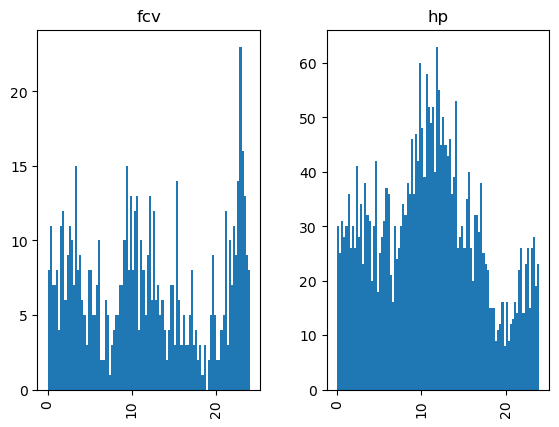

In [77]:
day_of_week = df.hist("timeofday", bins=96, range=(0, 24), by='list')

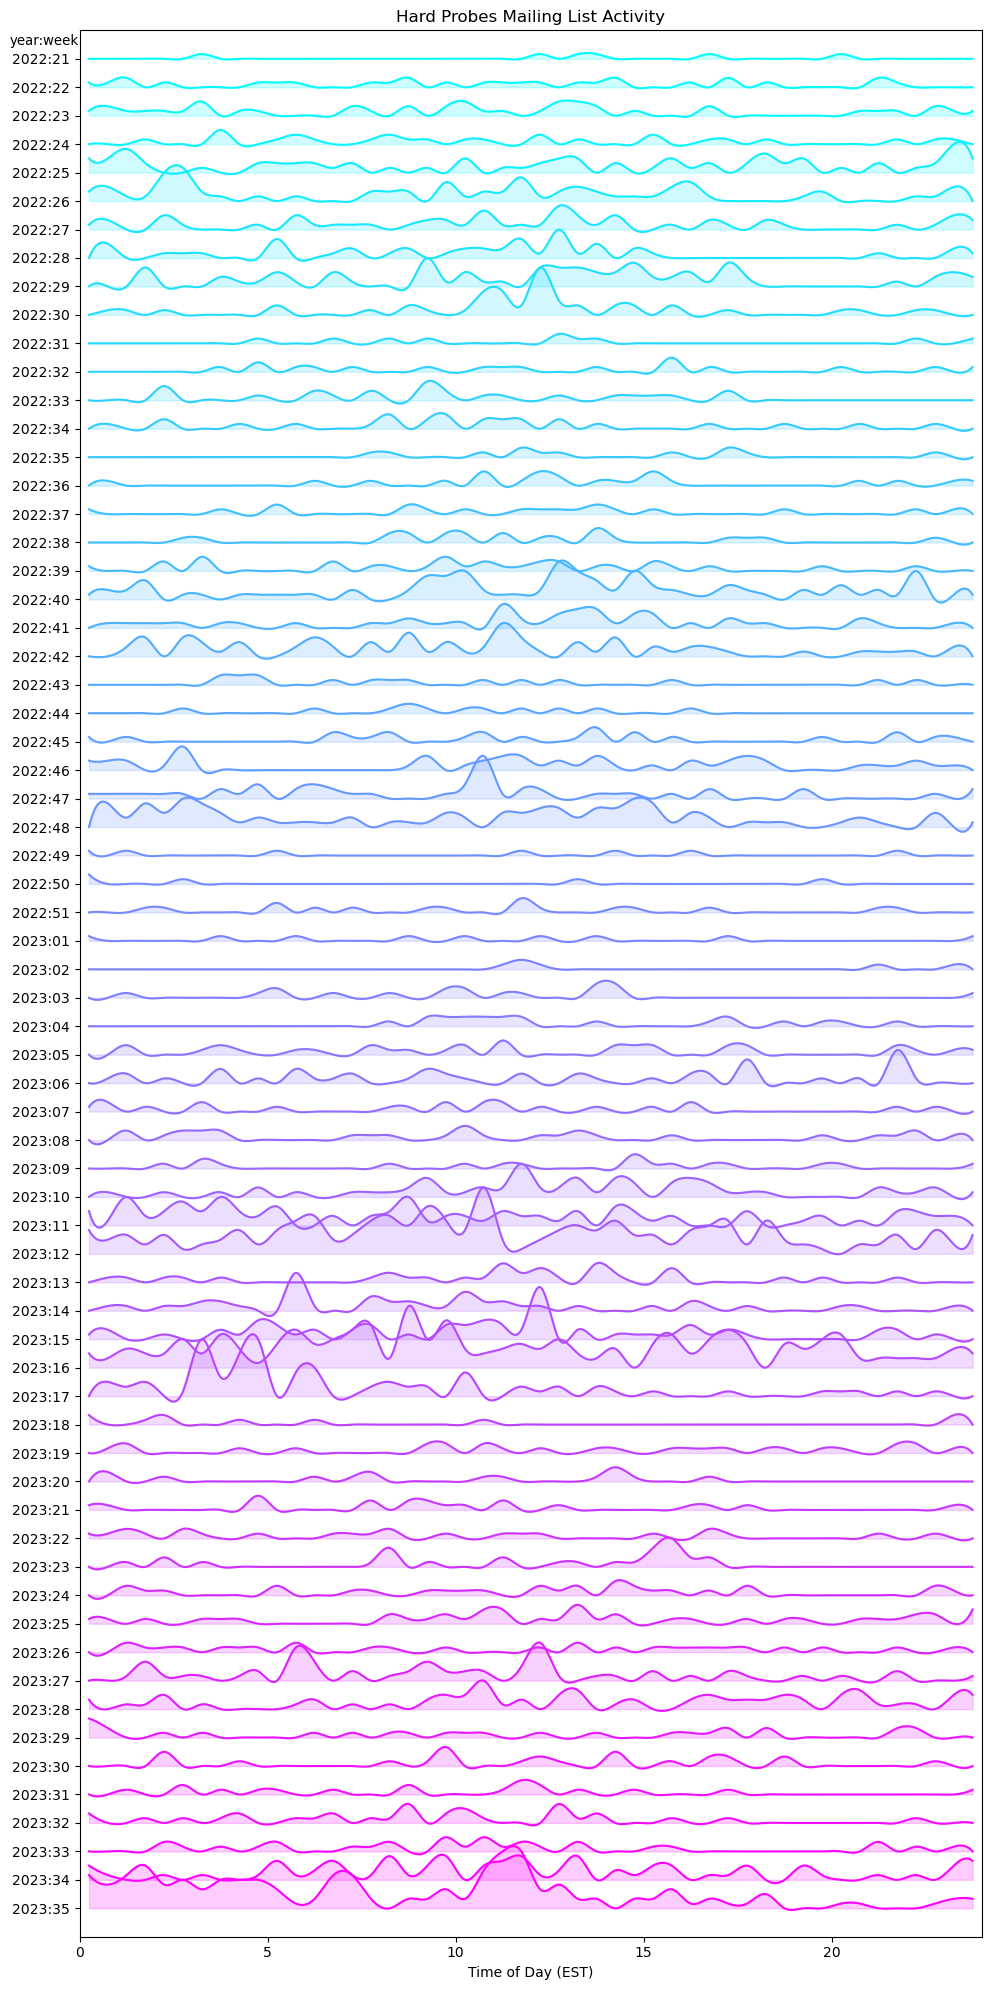

In [76]:
# time_of_day = df.hist('timeofday', bins=96, range=(0, 24), by='list')
time_of_day = [s for s in df[df['list']=='hp'].groupby('weekyear')['timeofday']]
# time_of_day = [s for s in df[df['list']=='fcv'].groupby('weekyear')['timeofday']]

normalization = 6
# plt.style.use('dark_background')
plt.style.use('default')

figure = plt.figure(figsize=(10, 20))
total_weeks = len(time_of_day) - 1
y_pos = []
y_label = []

import matplotlib.cm as cm
colors = cm.cool(np.linspace(0, 1, len(time_of_day)))

for i, week in enumerate(time_of_day):
    y_pos.append(total_weeks - i)
    y_label.append(week[0])
    

    values, bins = np.histogram(week[1], bins=48, range=(0, 24))
    midpoint = (bins[:-1] + bins[1:]) / 2
    B_spline_coeff = make_interp_spline(midpoint, values)
    X_Final = np.linspace(midpoint.min(), midpoint.max(), 500)
    Y_Final = B_spline_coeff(X_Final)

    # plt.plot(midpoint, (values / normalization) + total_weeks - i, total_weeks - i, alpha=0.7)
    plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color=colors[i])
    plt.fill_between(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=0.2, color=colors[i])
    # plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color='white')


# plt.axis('off')
plt.yticks(y_pos, y_label)
plt.xlim(0, 24)
plt.ylim(-1, total_weeks+1)
plt.xlabel("Time of Day (EST)")
plt.title("Hard Probes Mailing List Activity")
plt.savefig('hp.png', dpi=300)
plt.text(-1.85, total_weeks+0.5, "year:week", fontsize=9.6)
plt.tight_layout()

# plt.violinplot(time_of_day)
# plt.show()

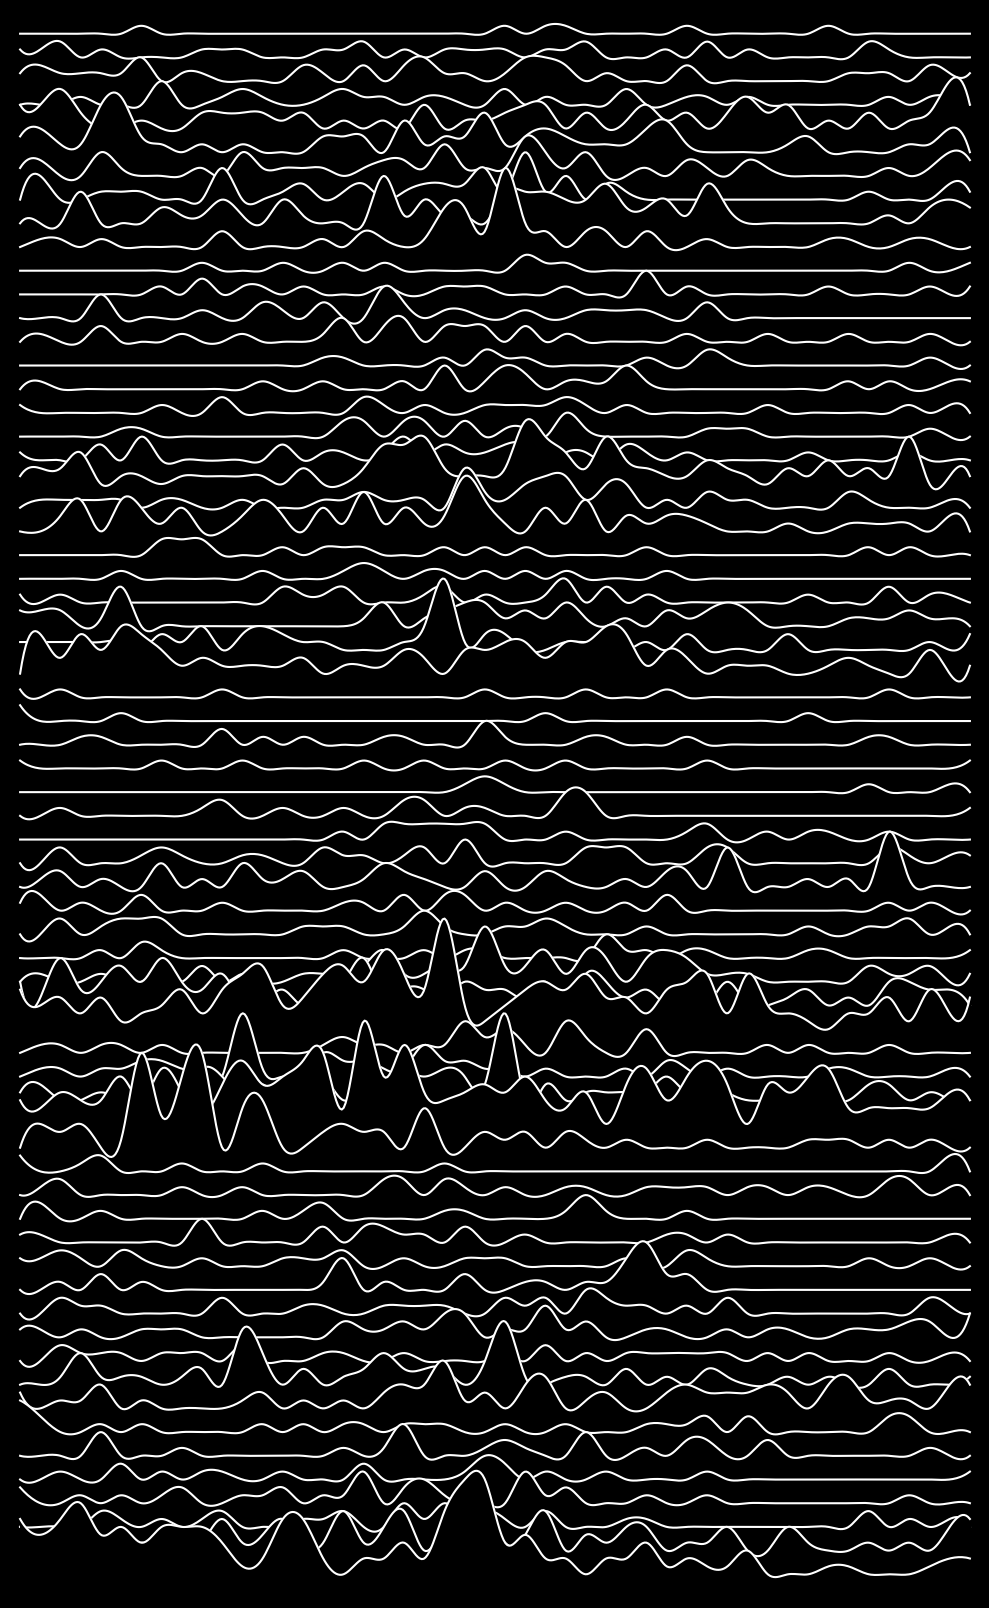

In [74]:
# time_of_day = df.hist('timeofday', bins=96, range=(0, 24), by='list')
time_of_day = [s for s in df[df['list']=='hp'].groupby('weekyear')['timeofday']]
# time_of_day = [s for s in df[df['list']=='fcv'].groupby('weekyear')['timeofday']]

normalization = 3
plt.style.use('dark_background')
# plt.style.use('default')

figure = plt.figure(figsize=(10, 16.18))
total_weeks = len(time_of_day) - 1
y_pos = []
y_label = []

import matplotlib.cm as cm
colors = cm.cool(np.linspace(0, 1, len(time_of_day)))

for i, week in enumerate(time_of_day):
    y_pos.append(total_weeks - i)
    y_label.append(week[0])
    

    values, bins = np.histogram(week[1], bins=48, range=(0, 24))
    midpoint = (bins[:-1] + bins[1:]) / 2
    B_spline_coeff = make_interp_spline(midpoint, values)
    X_Final = np.linspace(midpoint.min(), midpoint.max(), 500)
    Y_Final = B_spline_coeff(X_Final)

    # plt.plot(midpoint, (values / normalization) + total_weeks - i, total_weeks - i, alpha=0.7)
    # plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color=colors[i])
    # plt.fill_between(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=0.2, color=colors[i])
    plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color='white', zorder=i + 0.1)
    plt.fill_between(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color='black', zorder=i)


plt.axis('off')
plt.yticks(y_pos, y_label)
plt.xlim(0, 24)
plt.ylim(-1, total_weeks+1)
plt.xlabel("Time of Day (EST)")
# plt.title("Hard Probes Mailing List Activity")
plt.savefig('hp_darkmode.png', dpi=300)
plt.savefig('hp_darkmode.pdf', dpi=300)
# plt.text(-1.85, total_weeks+0.5, "year:week", fontsize=9.6)
plt.tight_layout()

# plt.violinplot(time_of_day)
# plt.show()

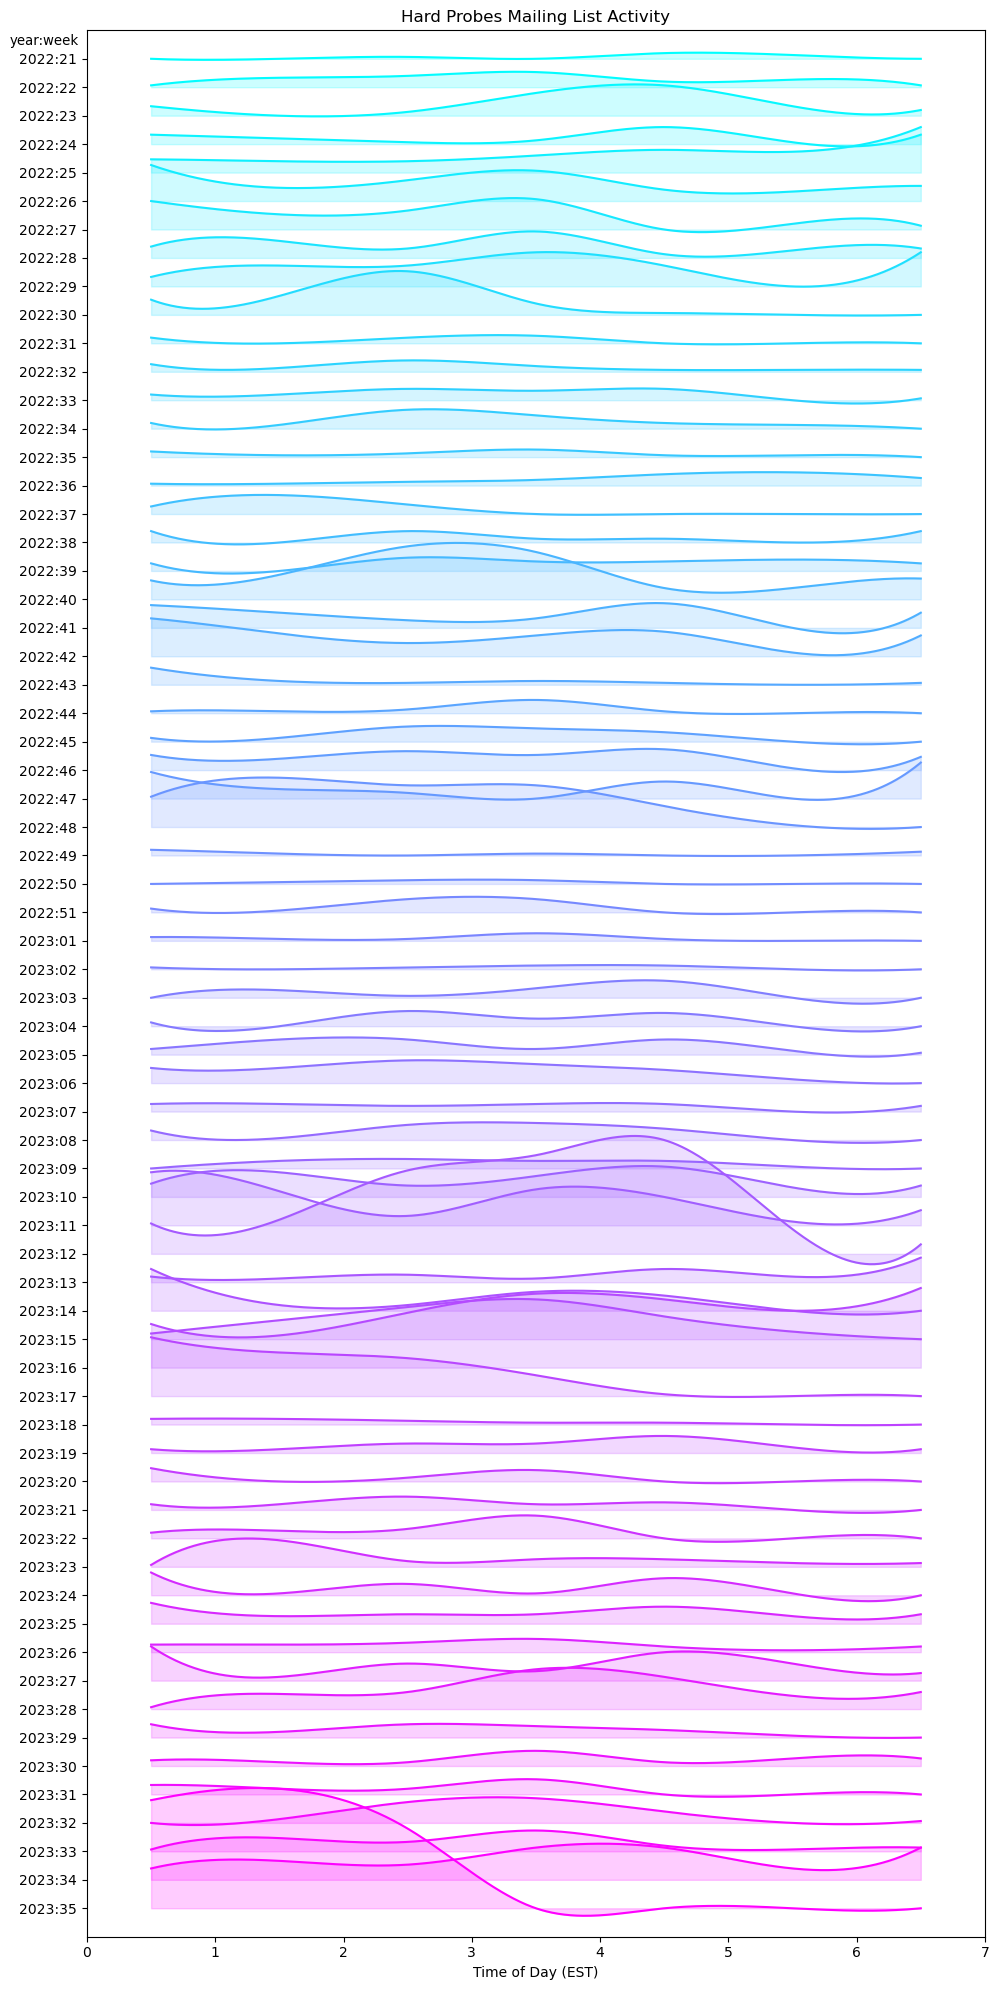

In [61]:
# time_of_day = df.hist('timeofday', bins=96, range=(0, 24), by='list')
time_of_day = [s for s in df[df['list']=='hp'].groupby('weekyear')['weekday']]
# time_of_day = [s for s in df[df['list']=='fcv'].groupby('weekyear')['timeofday']]

normalization = 15
# plt.style.use('dark_background')
plt.style.use('default')

figure = plt.figure(figsize=(10, 20))
total_weeks = len(time_of_day) - 1
y_pos = []
y_label = []

import matplotlib.cm as cm
colors = cm.cool(np.linspace(0, 1, len(time_of_day)))

for i, week in enumerate(time_of_day):
    y_pos.append(total_weeks - i)
    y_label.append(week[0])
    

    values, bins = np.histogram(week[1], bins=7, range=(0, 7))
    midpoint = (bins[:-1] + bins[1:]) / 2
    B_spline_coeff = make_interp_spline(midpoint, values)
    X_Final = np.linspace(midpoint.min(), midpoint.max(), 500)
    Y_Final = B_spline_coeff(X_Final)

    # plt.plot(midpoint, (values / normalization) + total_weeks - i, total_weeks - i, alpha=0.7)
    plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color=colors[i])
    plt.fill_between(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=0.2, color=colors[i])
    # plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color='white')


# plt.axis('off')
plt.yticks(y_pos, y_label)
plt.xlim(0, 7)
plt.ylim(-1, total_weeks+1)
plt.xlabel("Time of Day (EST)")
plt.title("Hard Probes Mailing List Activity")
plt.savefig('hp.png', dpi=300)
plt.text(-0.6, total_weeks+0.5, "year:week", fontsize=9.6)
plt.tight_layout()

# plt.violinplot(time_of_day)
# plt.show()

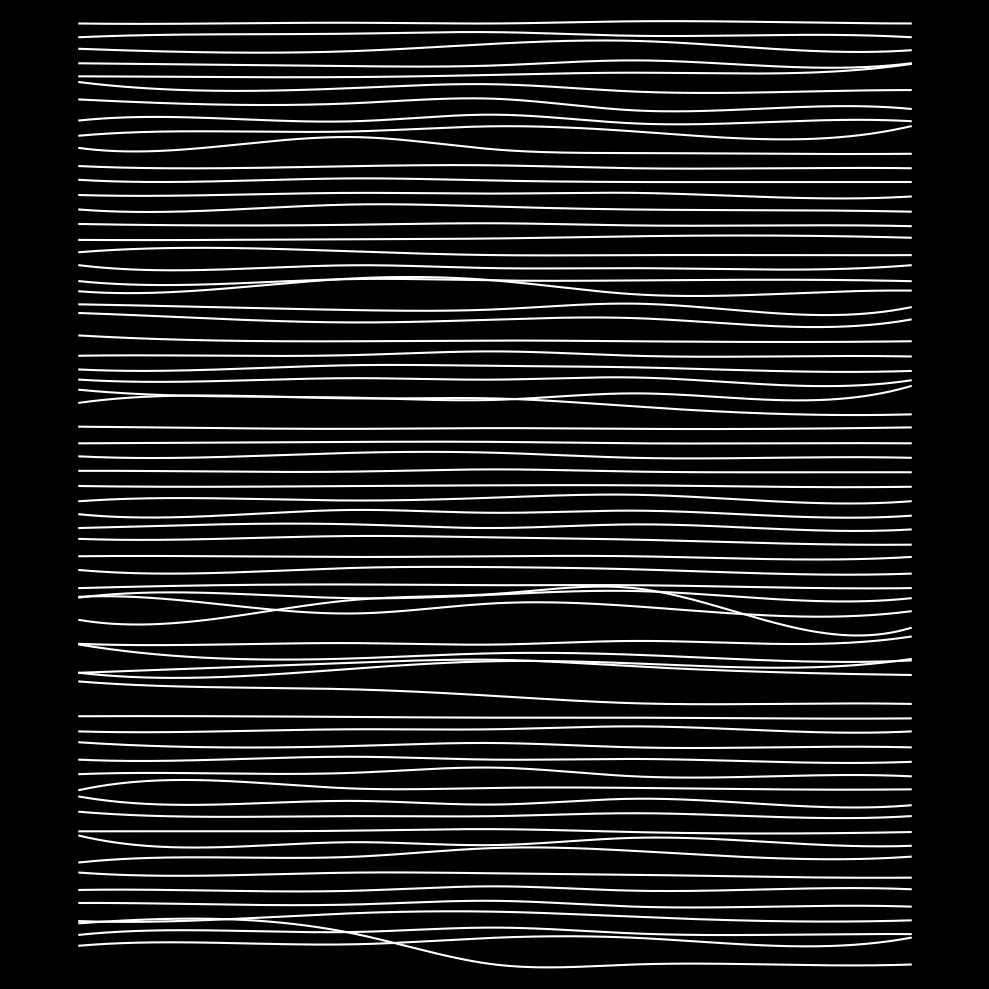

In [48]:
# time_of_day = df.hist('timeofday', bins=96, range=(0, 24), by='list')
time_of_day = [s for s in df[df['list']=='hp'].groupby('weekyear')['weekday']]
# time_of_day = [s for s in df[df['list']=='fcv'].groupby('weekyear')['timeofday']]

normalization = 20
plt.style.use('dark_background')
# plt.style.use('default')

figure = plt.figure(figsize=(10, 10))
total_weeks = len(time_of_day) - 1
y_pos = []
y_label = []

import matplotlib.cm as cm
colors = cm.cool(np.linspace(0, 1, len(time_of_day)))

for i, week in enumerate(time_of_day):
    y_pos.append(total_weeks - i)
    y_label.append(week[0])
    

    values, bins = np.histogram(week[1], bins=7, range=(0, 7))
    midpoint = (bins[:-1] + bins[1:]) / 2
    B_spline_coeff = make_interp_spline(midpoint, values)
    X_Final = np.linspace(midpoint.min(), midpoint.max(), 500)
    Y_Final = B_spline_coeff(X_Final)

    # plt.plot(midpoint, (values / normalization) + total_weeks - i, total_weeks - i, alpha=0.7)
    # plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color=colors[i])
    # plt.fill_between(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=0.2, color=colors[i])
    plt.plot(X_Final, (Y_Final / normalization) + total_weeks - i, total_weeks - i, alpha=1, color='white')


plt.axis('off')
plt.yticks(y_pos, y_label)
plt.xlim(0, 7)
plt.ylim(-1, total_weeks+1)
plt.xlabel("Time of Day (EST)")
# plt.title("Hard Probes Mailing List Activity")
plt.savefig('hp.png', dpi=300)
# plt.text(-1.85, total_weeks+0.5, "year:week", fontsize=9.6)
plt.tight_layout()

# plt.violinplot(time_of_day)
# plt.show()